# Context
This notebook contains the initial preliminary and exploratory analysis of the data from the Santander Kaggle competition [Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-prediction/overview).

The initial analysis is two-fold:
* Basic exploratory analysis and data characterization.
* Basic modelling.

The goal is to provide a grasp of the data provided, and it should be taken as that. **The goal**, at this stage, **is not to provide a full data characterization, not is it to provide some real modelling power, but rather to provide initial insights into the data being handled as well as to provide baseline results for modelling**.

Based on what is to be identified along the way, a thorough analysis is to be performed.

Any documentation being generated in this notebook is to be saved in the [doc](../doc) directory, namely [preliminary analysis](../doc/preliminary_analysis) where there is also a dir with the plots generated.

# Exploratory data analysis and characterization
As the very basics, the code below provides an insight into:
- data shape (the amount and type of data being handled).
- presence or absence of null values and outliers.
- some basic statistics and visualizations of the data.

# Basic modelling
In terms of modelling, three modelling techniques are used (from the [scikit-learn](https://scikit-learn.org/stable/index.html) package):
* [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [k Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

## Note
**For evaluation** purposes, we need to **split the train data into train and test**, or more preciselly into **train and validation**, as the test data set is provided, though, as it is intended for competition purposes, there are no target values. The validation is thus to provide a sense of how the modelling is working.

In this initial characterization, only the train data set is used.

# Evaluation
For evaluation purposes, the following metrics will be computed (also from the [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) package):
* Accuracy
* Precision
* Recall
* F1 score
* Area under the ROC curve (this is also the metric used for evaluation in the Kaggle competition).

In [1]:
import shutil
shutil.which('python')

'/Users/ghostsnstuff/Documents/developing/venv/base_ml/bin/python'

In [2]:
import io
import pandas as pd
from pandas.api.types import infer_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

start_time_dt = datetime.now()

seed = 101101011
str_block_separator = "*****************************************************"
base_dir = '..'
base_output_dir = base_dir + '/doc/preliminary_analysis'

save_outputs = True

In [3]:
def save_output_file(msg, filename, save_dir=None, fextension='.txt', override=False):
    write_mode = 'w' if override else 'a'
    if save_dir is None:
        output_file = base_output_dir + '/' + filename + fextension
    else:
        output_file = save_dir + '/' + filename + fextension
        
    with open(output_file, write_mode) as f:
        print(msg, file=f)
        
def save_output_plots(pltname, save_dir=None, pltextension='.svg'):
    if save_dir is None:
        plot_dir = base_output_dir + '/plots' + pltname + pltextension
    else:
        plot_dir = save_dir + '/' + pltname + pltextension
        
    plt.savefig(plot_dir, transparent=True, bbox_inches='tight')

In [4]:
start_time_load_dt = datetime.now()
zip_file = ZipFile(base_dir + '/data/santander-customer-transaction-prediction.zip')
train_df = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
              for text_file in zip_file.infolist()
              if text_file.filename == 'train.csv'}
train_df = train_df.pop('train.csv')

load_data_dt = datetime.now() - start_time_load_dt

load_data_dt_msg = 'Time to load train data: {}'.format(load_data_dt)
print(load_data_dt_msg)

Time to load train data: 0:00:10.555641


In [5]:
start_time_basic_info_dt = datetime.now()

# get basic info:
train_shape = train_df.shape

basic_prints_msg = (
    "** Shape: {}\n"
    "**Head(3): \n{}\n{}\n"
    "**Tail(3): \n{}\n{}\n"
).format(
    train_shape,
    train_df.head(3), str_block_separator,
    train_df.tail(3), str_block_separator,
)

print(basic_prints_msg)

** Shape: (200000, 202)
**Head(3): 
   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  

[3 rows x 202 columns]
*****************************************************
**Tail(3): 
             ID_code  target    var_0   var_1    var_2   var_3    var_4  \
199997  train_199997 

In [6]:
# the .info() returns nothing, prints to stdout. In order to save it, one needs to use a buffer.
# see : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html
buffer = io.StringIO()
train_df.info(buf=buffer)
s = buffer.getvalue()

pd_info_msg = "**.info():\n{}".format(s)
print(pd_info_msg)

**.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB



In [7]:
# Column types
train_cols = train_df.columns
train_col_types = [infer_dtype(train_df[col_name]) for col_name in train_cols]

# just for analytical check - as the docs refers that the features are numeric
train_col_type_str = sum(1 if col_type == 'string' else 0 for col_type in train_col_types) # there is 1 - ID, which is dropped
train_col_type_int = sum(1 if col_type == 'integer' else 0 for col_type in train_col_types) # there is 1 - the target variable (takes values 0 and 1)
train_col_type_float = sum(1 if col_type == 'floating' else 0 for col_type in train_col_types) # there are 200 - all the features are numeric

col_types_msg = (
    "*Number of columns of type:\n"
    "String: {}\n"
    "Int: {}\n"
    "Float: {}\n"
).format(
    train_col_type_str, train_col_type_int, train_col_type_float
)

print(col_types_msg)

*Number of columns of type:
String: 1
Int: 1
Float: 200



In [8]:
basic_info_msg = (
    "Basic info regarding the train data set\n{}\n"
    "{}"
    "{}"
    "{}"
    "{}"
).format(
    str_block_separator,
    load_data_dt_msg,
    basic_prints_msg,
    pd_info_msg,
    col_types_msg
)
print(basic_info_msg)

Basic info regarding the train data set
*****************************************************
Time to load train data: 0:00:10.555641** Shape: (200000, 202)
**Head(3): 
   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  

[3 rows x 202 columns]
*****************************

In [9]:
num_col_names = train_df.drop(columns=['ID_code', 'target']).columns.tolist()
cat_col_names = []
ord_col_names = []

In [10]:
# distribution of the target
tgt_distr = train_df['target'].value_counts()

tgt_distr_msg = '*Distribution of the target value (y) in the training set\n{}\n'.format(tgt_distr, tgt_distr/len(train_df))

# description of the target
tgt_descr = train_df.describe()['target']

# NA values
nas = train_df.isna().sum()[train_df.isna().sum()>0].to_dict()
var_nas = list(nas.keys())
nas_msg = "*Variables with NA values:\n{}\n".format(nas)
print(tgt_distr_msg, nas_msg)

*Distribution of the target value (y) in the training set
0    179902
1     20098
Name: target, dtype: int64
 *Variables with NA values:
{}



In [11]:
# duplicate records or variables
# rows
duplicate_records = train_df.duplicated().sum()

# columns
duplicate_features = train_df.T.duplicated().sum()

duplicate_msg = "*Duplicates:\nRecords: {}\nFeatures: {}\n".format(duplicate_records, duplicate_features)

print(duplicate_msg) # 0, 0

*Duplicates:
Records: 0
Features: 0



In [12]:
# correlation between variables
vars_cross_correl = train_df.corr()
vars_correl_to_tgt = train_df.corr()['target'].sort_index(ascending=False)

vars_correl_max_positive = vars_cross_correl.nlargest(5, num_col_names)
vars_correl_max_negative = vars_cross_correl.nsmallest(5, num_col_names)

vars_correl_to_tgt_max_positive = vars_correl_to_tgt.nlargest(5)
vars_correl_to_tgt_max_negative = vars_correl_to_tgt.nsmallest(5)

correl_msg = ("*Correlations.\n"
              "Variables cross correlations:\n{}\n"
              "Variables correlation to target:\n{}\n"
              "Variables max correlation to target:\nPositive: {}\nNegative: {}\n".format(
                  vars_cross_correl,
                  vars_correl_to_tgt,
                  vars_correl_to_tgt_max_positive, vars_correl_to_tgt_max_negative                  
              )
             )

# message with basic computations
get_basic_info_dt = datetime.now() - start_time_basic_info_dt
get_info_dt_msg = 'Time to compute basic info: {}\n'.format(get_basic_info_dt)

prelim_anal_msg = (
    "Preliminary analysis regarding train data\n{}\n"
    "{}"
    "{}"
    "{}"
    "{}"
    "{}"
).format(
    str_block_separator,
    tgt_distr_msg,
    nas_msg,
    duplicate_msg,
    correl_msg,
    get_info_dt_msg
)

In [13]:
msg = (
    "{}"
    "{}\n"
    "{}"
    "{}"
).format(
    basic_info_msg,
    str_block_separator + str_block_separator + str_block_separator,
    prelim_anal_msg,
    str_block_separator
)

print(msg)

if save_outputs:
    msg = (
        "{}"
        "{}\n"
        "{}"
        "{}"
    ).format(
        basic_info_msg,
        str_block_separator + str_block_separator + str_block_separator,
        prelim_anal_msg,
        str_block_separator
    )
    save_output_file(msg, 'output')

Basic info regarding the train data set
*****************************************************
Time to load train data: 0:00:10.555641** Shape: (200000, 202)
**Head(3): 
   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  

[3 rows x 202 columns]
*****************************

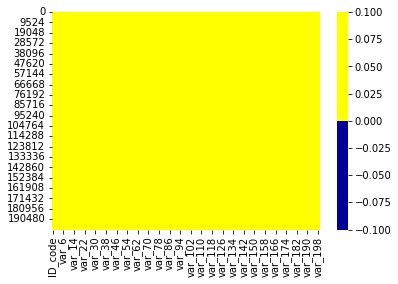

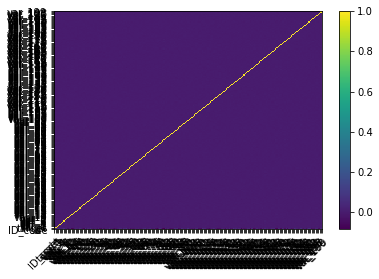

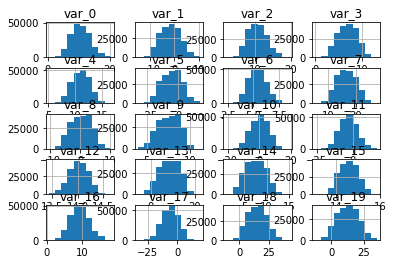

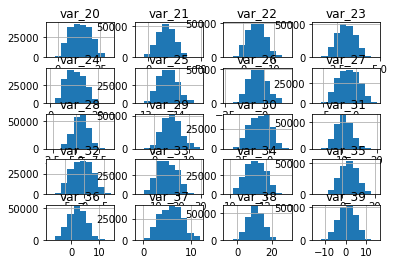

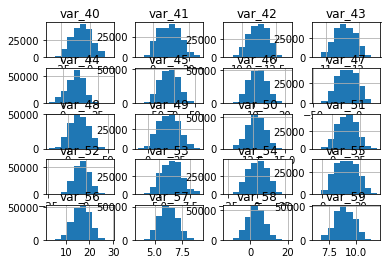

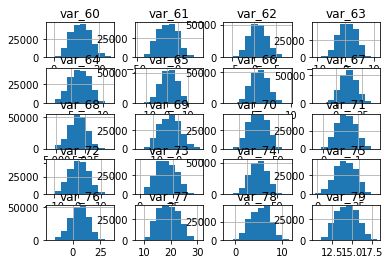

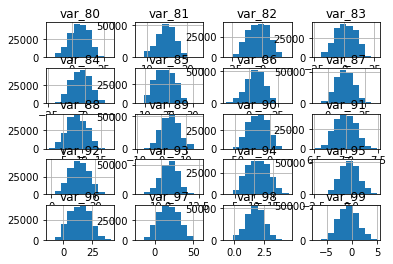

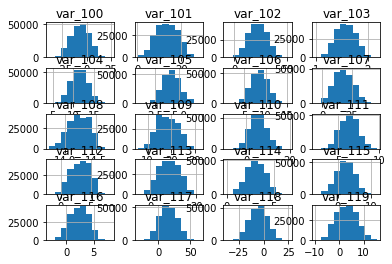

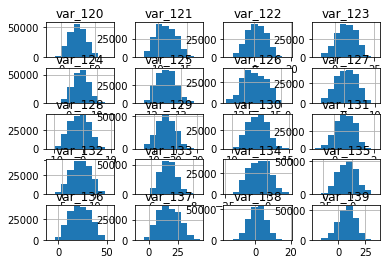

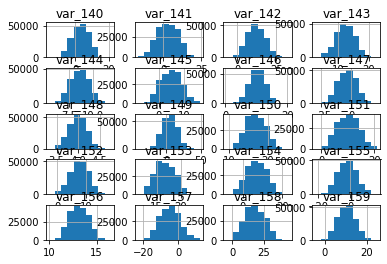

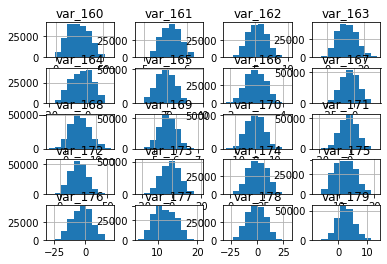

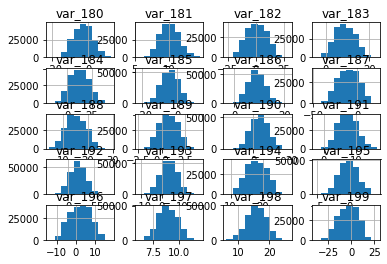

In [14]:
start_time_plots = datetime.now()

## NAs visually
colours = ['#000099', '#ffff00']
sns.heatmap(train_df[train_cols].isnull(), cmap=sns.color_palette(colours))

if save_outputs:
    save_output_plots('vars_nas_vals')
    
# visualize correlations using heatmap
fig, ax = plt.subplots()
heatmap = plt.pcolor(train_df.corr())
cbar = plt.colorbar(heatmap)
ax.set_xticks(np.arange(len(train_df.columns)))
ax.set_yticks(np.arange(len(train_df.columns)))
ax.set_xticklabels(train_df.columns)
ax.set_yticklabels(train_df.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

if save_outputs:
    save_output_plots('vars_corr_to_target')

# numeric vars histograms
num_var_groups = [
    num_col_names[0:20], num_col_names[20:40], num_col_names[40:60], num_col_names[60:80], num_col_names[80:100],
    num_col_names[100:120], num_col_names[120:140], num_col_names[140:160], num_col_names[160:180], num_col_names[180:200]
]

for group in num_var_groups:
    train_df.loc[:, group].hist()
    if True:
        filename = '{}_to_{}_vars_histogram'.format(group[0], group[-1])
        save_output_plots(filename)
        
plt.show()

# Preliminary data analysis

Regarding the train data, there are **200000 records**, each having 202 features. If we discard the ID and the target, there are a total of **200 variables**.

Regarding the **target variable**, its distribution is as follows:

|Class|Count|Percentage|
|-|-|-|
|0|179902|0.90|
|1|20098|0.10|

We can see that the **dataset is unbalanced - about 90% of one class**.

> It might be useful to use some pre-processing tecnhiques, namely by setting the train and test data sets using oversampling, in order to improve results -> to be evaluated at a later stage.

Regarding the distribution of the values for all the variables, an histogram was computed for each. As a rough visual analysis, we may conclude that, with a few exception, almost all variables approximatelly follow a normal distribution -> evaluate analytically.
Regarding the values, they take, this varies widely, with some variables only taking positive values, and the same not being true for the others.

> It is required to use scalling, as the amplitude of the values each variables takes varies widely (in order to avoid the effects of magnitude). Some scallers need to be tested, but here the z-score will be used for preliminary tests (seems reasonable, considering that visually they seem to approximately follow a normal distribution).

With relation to **null values**, which are set under the `var_nas` variable, we see that **there are no null values** in any variable.

There is a different matter of understanding if any of the values does not make sense in the context of the problem. However as the data provider does not provide any indication with regards to variable meaning (and we know that at least some treatment to the variables was performed in order to anonimize the data) there is not an easy way to uncover that. We could perform some outlier detection analysis, and even removing any data point regarded as outlier, but without knowing more about the context of the variables, I do not feel comfortable with that approach, at least at this stage. For now, I will **assume that there are no null/na values, nor outliers**.

Another type of analysis performed was the *correlation between variables* (see `vars_cross_correl`) and, more specifically, in relation to the target variable (see variable `vars_correl_to_tgt`).
The maximum value obtained between any single variable and the target is 0.066731 for positive correlation, and -0.08917 for negative correlation - as such we conclude that **there is no significant correlation between a single variable and the target (nor between variables, for that matter)**.

The last plot represents this correlation between all the variables, and it is possible to (visually) realize that - there is no significant correlation.
There is a yellow strip in the main diagonal, but that is the representation of the variable against itself (thus maximum corelation value at 1, represented in yellow). Other than that, all regions are in the shades of purple, denoting low correlation values.

# Modelling

In [15]:
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    """n_classes = y_true.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])"""
    
    return accuracy, f1, precision, recall

In [16]:
# create train and test data sets
X = train_df.drop(columns=['ID_code', 'target'])
Y = train_df['target']

test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed, stratify=Y)

In [17]:
# pre-processing - scale numeric features
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_col_names)
    ]
)

In [18]:
# Append classifier to pre-processing pipeline
full_pipe_dt = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('class_dt', DecisionTreeClassifier(random_state=seed))
    ]
)

start_time_dt = datetime.now()
full_pipe_dt.fit(X_train, y_train)
train_dt_runtime = datetime.now() - start_time_dt

full_pipe_lr = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('class_lr', LogisticRegression(n_jobs=-1))
    ]
)

start_time_lr = datetime.now()
full_pipe_lr.fit(X_train, y_train)
train_lr_runtime = datetime.now() - start_time_lr

full_pipe_knn = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('class_knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
    ]
)

start_time_knn = datetime.now()
full_pipe_knn.fit(X_train, y_train)
train_knn_runtime = datetime.now() - start_time_knn

full_pipe_svc = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('class_svc', SVC())
    ]
)

start_time_svc = datetime.now()
full_pipe_svc.fit(X_train, y_train)
train_svc_runtime = datetime.now() - start_time_svc

In [19]:
dt_pipe_pred = full_pipe_dt.predict(X_test)
dt_pipe_metrics = get_metrics(y_test, dt_pipe_pred)
print(round(dt_pipe_metrics[0], 3), round(dt_pipe_metrics[1], 3), round(dt_pipe_metrics[2], 3), round(dt_pipe_metrics[3], 3))

0.837 0.208 0.203 0.213


In [20]:
lr_pipe_pred = full_pipe_lr.predict(X_test)
lr_pipe_metrics = get_metrics(y_test, lr_pipe_pred)
print(round(lr_pipe_metrics[0], 3), round(lr_pipe_metrics[1], 3), round(lr_pipe_metrics[2], 3), round(lr_pipe_metrics[3], 3))

0.914 0.387 0.685 0.27


In [21]:
knn_pipe_pred = full_pipe_knn.predict(X_test)
knn_pipe_metrics = get_metrics(y_test, knn_pipe_pred)
print(round(knn_pipe_metrics[0], 3), round(knn_pipe_metrics[1], 3), round(knn_pipe_metrics[2], 3), round(knn_pipe_metrics[3], 3))

0.899 0.002 0.368 0.001


In [22]:
svc_pipe_pred = full_pipe_svc.predict(X_test)
svc_pipe_metrics = get_metrics(y_test, svc_pipe_pred)
print(round(svc_pipe_metrics[0], 3), round(svc_pipe_metrics[1], 3), round(svc_pipe_metrics[2], 3), round(svc_pipe_metrics[3], 3))

0.916 0.36 0.766 0.235


In [23]:
prt_msg_modelling_info = (
    "{}\nBasic modelling info:\n{}\n"
    "{} Decision Tree\n"
    "DT evaluation metrics:\naccuracy: {}\nf1 score: {}\nprecision: {}\nrecall: {}\nRun time: {}"
    "{} Logistic Regression\n"
    "LR evaluation metrics:\naccuracy: {}\nf1 score: {}\nprecision: {}\nrecall: {}\nRun time: {}"
    "{} k Nearest Neighbors\n"
    "kNN evaluation metrics:\naccuracy: {}\nf1 score: {}\nprecision: {}\nrecall: {}\nRun time: {}"
    "{} Support Vector Machines\n"
    "SVM evaluation metrics:\naccuracy: {}\nf1 score: {}\nprecision: {}\nrecall: {}\nRun time: {}"
).format(
    str_block_separator, str_block_separator,
    str_block_separator,
    round(dt_pipe_metrics[0], 4), round(dt_pipe_metrics[1], 4), round(dt_pipe_metrics[2], 4), round(dt_pipe_metrics[3], 4), train_dt_runtime,
    str_block_separator,
    round(lr_pipe_metrics[0], 4), round(lr_pipe_metrics[1], 4), round(lr_pipe_metrics[2], 4), round(lr_pipe_metrics[3], 4), train_lr_runtime,
    str_block_separator,
    round(knn_pipe_metrics[0], 4), round(knn_pipe_metrics[1], 4), round(knn_pipe_metrics[2], 4), round(knn_pipe_metrics[3], 4), train_knn_runtime,
    str_block_separator,
    round(svc_pipe_metrics[0], 4), round(svc_pipe_metrics[1], 4), round(svc_pipe_metrics[2], 4), round(svc_pipe_metrics[3], 4), train_svc_runtime
)

if save_outputs:
    save_output_file(prt_msg_modelling_info, 'output_basic_modelling', override=True)

# Preliminary modelling analysis

As mentioned above, this is a preliminary exploratory analysis whose results serve only as baseline.

## Methodology

In order to perform this analysis, the train data set is the only one used, as it is the only labeled data set.

To properly perform model evaluation, the data set is divided into a training and testing data set, using a proporting of `test_size = 0.3`.

# Submission

For submission purposes, to get a baseline result from the kaggle competition platform, a prediction with the model that yielded the best result is performed.

In [24]:
def prepare_submission(ids, predictions, filename='submission'):
    subm = pd.DataFrame(data={'ID_code':ids, 'target':predictions})
    subm.to_csv(path_or_buf=base_dir + '/submission/' + filename + '.csv', index=False)
    return subm    

In [25]:
zip_file = ZipFile(base_dir + '/data/santander-customer-transaction-prediction.zip')
test_df = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
              for text_file in zip_file.infolist()
              if text_file.filename == 'test.csv'}
test_df = test_df.pop('test.csv')


X_test = test_df.drop(columns=['ID_code'])
preds = full_pipe_svc.predict(X_test)

subm_file = prepare_submission(ids=test_df.iloc[:,0], predictions=preds, filename='submission_baseline')

In [26]:
subm_file.head(3)
subm_file['target'].value_counts()

0    195686
1      4314
Name: target, dtype: int64

# Submission baseline result (kaggle)
